In [ ]:
"""
  Final Project
  Restaurant Suggester
  Derek Zhang
  Data taken from https://www.kaggle.com/datasets/thedevastator/restaurant-and-consumer-context-aware-recommenda
"""

'\n  Final Project\n  Restaurant Suggester\n  Derek Zhang\n'

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
"""
  Exploratory Data Analysis
"""

# from google.colab import drive
# drive.mount('/content/drive')

# DATA_DIR = '/content/drive/MyDrive/College/CU Boulder/S3-1/Unsupervised Algorithms in Machine Learning/Final/'
DATA_DIR = './'

rating_df = pd.read_csv(os.path.join(DATA_DIR, 'rating_final.csv'))[['userID', 'placeID', 'rating']]
places_df = pd.read_csv(os.path.join(DATA_DIR, 'geoplaces2.csv'))[['placeID', 'name']]
restaurant_df = rating_df.merge(places_df, on='placeID', how='left')

user_item_matrix = restaurant_df.pivot(index='userID', columns='placeID', values='rating')
filled_matrix = user_item_matrix.fillna(0).values

n_components = 20
nmf = NMF(n_components=n_components, init='random', random_state=42)
W = nmf.fit_transform(filled_matrix)
H = nmf.components_

predicted_ratings = np.dot(W, H)

true_ratings = filled_matrix[filled_matrix.nonzero()]
predicted_ratings_filtered = predicted_ratings[filled_matrix.nonzero()]
rmse = sqrt(mean_squared_error(true_ratings, predicted_ratings_filtered))

print(f"RMSE: {rmse}")

RMSE: 0.843796614030384


For our initial exploratory data analysis, I constructed a matrix with the restaurant customers (users) and the customers' ratings of the restaurants. Using Sklearn's Non-Negative Matrix Factorization, we can see a RMSE of 0.84. Since the rating is from a scale of 0 (did not like) to 2 (liked), this appears to have a quite significant error.

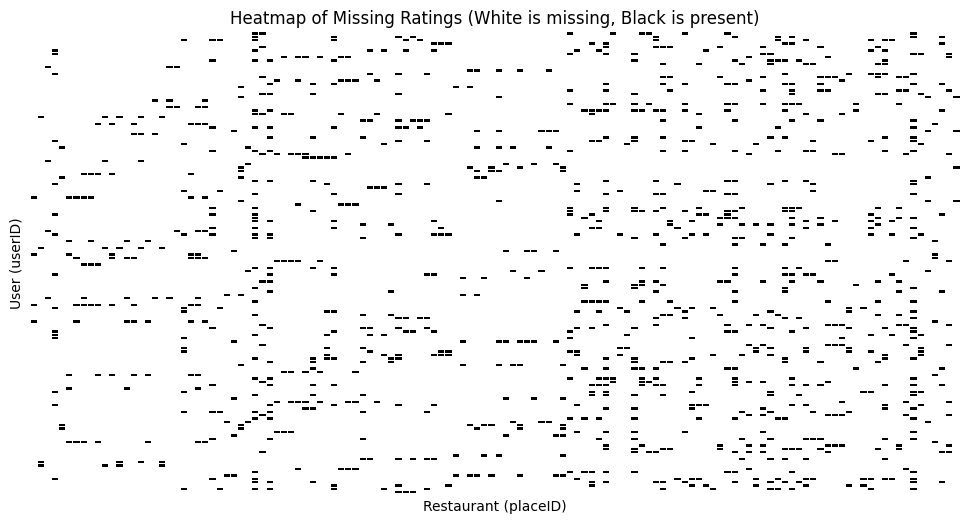

In [4]:
"""
  Exploratory Data Analysis Continued
"""

import seaborn as sns
import matplotlib.pyplot as plt

missing_values = user_item_matrix.isnull()
plt.figure(figsize=(12, 6))
sns.heatmap(missing_values, cmap=['black', 'white'], cbar=False, linewidths=0.5, xticklabels=False, yticklabels=False)

plt.xlabel("Restaurant (placeID)")
plt.ylabel("User (userID)")
plt.title("Heatmap of Missing Ratings (White is missing, Black is present)")

plt.show()

As the customer-restaurant heatmap shows, the dataset is quite sparse. In order to achieve more accurate predictions, we will need to use methods that are better suited for sparse datasets.

In [5]:
"""
  Collaborative Filtering and K-Nearest Neighbor Model
"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import os
from math import sqrt

train_df, test_df = train_test_split(restaurant_df, test_size=0.2, random_state=42)
user_item_matrix = train_df.pivot(index="userID", columns="placeID", values="rating").fillna(0)

k = 2
knn_model = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
knn_model.fit(user_item_matrix.T.values)

true_ratings = []
predicted_ratings = []

for _, row in test_df.iterrows():
    user_id = row["userID"]
    place_id = row["placeID"]
    actual_rating = row["rating"]

    if (user_id not in user_item_matrix.index) or (place_id not in user_item_matrix.columns):
        continue

    user_ratings = user_item_matrix.loc[user_id].values.reshape(1, -1)
    item_idx = user_item_matrix.columns.get_loc(place_id)
    item_vector = user_item_matrix.T.iloc[item_idx].values.reshape(1, -1)

    distances, indices = knn_model.kneighbors(item_vector, n_neighbors=k+1)
    similarities = 1 - distances.flatten()

    similarities = similarities[1:]
    indices = indices.flatten()[1:]

    similar_items_ratings = np.array([user_item_matrix.iloc[user_item_matrix.index.get_loc(user_id), idx]
                                    for idx in indices])

    if np.sum(similarities) > 0 and np.sum(similar_items_ratings > 0) > 0:
        mask = similar_items_ratings > 0
        if np.any(mask):
            used_similarities = similarities[mask]
            used_ratings = similar_items_ratings[mask]

            predicted_rating = np.sum(used_similarities * used_ratings) / np.sum(used_similarities)
            true_ratings.append(actual_rating)
            predicted_ratings.append(predicted_rating)

rmse = sqrt(mean_squared_error(true_ratings, predicted_ratings))
print(f"Model RMSE: {rmse}")

Model RMSE: 0.658452063222099


The K-Nearest Neighbors model (k = 2) performed marginally better than the Non-Negative Matrix Factorization with a RMSE of 0.66. This is a slight improvement, but is still far from accurate. This may be due to the fact that is it difficult to predict what kind of restaurant someone likes based purely on their habits, income, and such.

In [6]:
"""
  K-Nearest Neighbor Restaurant Prediction
"""

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from sklearn.preprocessing import LabelEncoder

def preprocess_user_data(user_attributes_df):
    user_attributes = user_attributes_df.copy()
    label_encoders = {}

    categorical_cols = user_attributes.select_dtypes(include=['object']).columns
    numerical_cols = user_attributes.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = [col for col in numerical_cols if col != 'userID']

    for col in categorical_cols:
        le = LabelEncoder()
        user_attributes[col] = le.fit_transform(user_attributes[col].astype(str))
        label_encoders[col] = le

    if len(numerical_cols) > 0:
        scaler = StandardScaler()
        user_attributes[numerical_cols] = scaler.fit_transform(user_attributes[numerical_cols])
    else:
        scaler = StandardScaler()

    return user_attributes, label_encoders, scaler

def train_knn(user_attributes_df, k=2):
    features = user_attributes_df.drop('userID', axis=1) if 'userID' in user_attributes_df.columns else user_attributes_df
    knn_model = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='brute')
    knn_model.fit(features)

    return knn_model

def get_top_n_restaurants(user_profile, user_attributes_df, user_item_matrix, knn_model, places_df, label_encoders, scaler, k=2, n=10):
    relevant_columns = [col for col in user_attributes_df.columns if col != 'userID']
    new_user_data = {}

    for col in relevant_columns:
        if col in user_profile:
            if col in label_encoders:
                try:
                    new_user_data[col] = label_encoders[col].transform([user_profile[col]])[0]
                except ValueError:
                    new_user_data[col] = 0
            else:
                new_user_data[col] = float(user_profile[col])
        else:
            if user_attributes_df[col].dtype in [np.float64, np.int64]:
                new_user_data[col] = user_attributes_df[col].mean()
            else:
                new_user_data[col] = 0

    feature_order = [col for col in relevant_columns]
    new_user_vector = np.array([new_user_data.get(col, 0) for col in feature_order]).reshape(1, -1)

    if new_user_vector.shape[1] == len(feature_order):
        try:
            new_user_vector = scaler.transform(new_user_vector)
        except:
          pass

    distances, indices = knn_model.kneighbors(new_user_vector, n_neighbors=min(k, len(user_attributes_df)))
    similar_users = user_attributes_df.iloc[indices.flatten()]["userID"].tolist()
    similar_users_ratings = user_item_matrix.loc[user_item_matrix.index.isin(similar_users)]

    avg_ratings = similar_users_ratings.mean().sort_values(ascending=False)
    top_restaurants = avg_ratings.index[:min(n, len(avg_ratings))]

    return places_df[places_df["placeID"].isin(top_restaurants)]["name"].tolist()

user_columns = ['userID', 'smoker', 'drink_level', 'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
                'birth_year', 'interest', 'personality', 'religion', 'activity', 'weight', 'budget', 'height']
user_df = pd.read_csv(os.path.join(DATA_DIR, 'userprofile.csv'))[user_columns]
encoded_user_df, label_encoders, scaler = preprocess_user_data(user_df)
knn_model = train_knn(encoded_user_df)

user_profile = {
    "smoker": "false",
    "drink_level": "social drinker",
    "dress_preference": "informal",
    "ambience": "family",
    "transport": "car owner",
}

recommended_restaurants = get_top_n_restaurants(user_profile, user_df, user_item_matrix, knn_model, places_df, label_encoders, scaler)
print(recommended_restaurants)

['Kiku Cuernavaca', 'Giovannis', 'Mariscos Tia Licha', 'Vips', 'Restaurant la Chalita', 'Restaurante Casa de las Flores', 'Restaurante Bar Fu-hao', 'Restaurant Las Mananitas', 'McDonalds Centro', 'Restaurant Bar Coty y Pablo']


Using a K-Nearest Neighbor model, we can try to predict which restaurants a user will like the most based on their profile. Feel free to play around with the profile values.

Here are the parameters with their possible values:

* smoker: [false,true]
* drink_level: [abstemious,social drinker,casual drinker]
* dress_preference: [informal,formal,no preference,elegant]
* ambience: [family,friends,solitary]
* transport: [on foot,public,car owner]
* marital_status:	[single,married,widow]
* hijos: [independent,kids,dependent]
* birth_year:	Integer
* interest: [variety,technology,none,retro,eco-friendly]
* personality: [thrifty-protector,hunter-ostentatious,hard-worker,conformist]
* religion: [none,Catholic,Christian,Mormon,Jewish]
* weight: Numeric
* budget: [medium,low,high]
* height: Numeric

